# Face Mask Detection Using MobileNetV2

## 1. Project Overview
This notebook builds a deep learning model to classify whether a person is wearing a mask or not using MobileNetV2 and transfer learning.

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset')

## 2. Import Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

## 3. Define Dataset Paths

In [3]:
base_dir = "face-mask-12k-images-dataset/Face Mask Dataset"
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Test")

## 4. Set Parameters

In [4]:
# Parameters
INIT_LR = 1e-4
EPOCHS = 20
BATCH_SIZE  = 32
IMG_SIZE = (224, 224)

In [5]:
# Data augmentation and preprocessing
train_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=20,
                               zoom_range=0.15,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.15,
                               horizontal_flip=True)

val_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_aug.flow_from_directory(train_dir,
                                          target_size=IMG_SIZE,
                                          batch_size=BATCH_SIZE,
                                          class_mode='binary') # Changed to binary

val_gen = val_aug.flow_from_directory(val_dir,
                                      target_size=IMG_SIZE,
                                      batch_size=BATCH_SIZE,
                                      class_mode='binary') # Changed to binary
test_gen = val_aug.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary', # Changed to binary
    shuffle=False
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


## 6. Load and Freeze MobileNetV2 Base Model

In [6]:
# Load base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# Freeze all layers
base_model.trainable = False

## 7. Build Full Model using Sequential API

In [7]:
# Create the full model
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),         
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Changed to 1 output with sigmoid for binary classification
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 8. Compile the Model

In [8]:
model.compile(
    optimizer=Adam(learning_rate=INIT_LR),
    loss='binary_crossentropy',  # Changed to binary_crossentropy
    metrics=['accuracy']
)

In [9]:
# Callbacks
checkpoint = ModelCheckpoint(
    "mask_detector_sigmoid_best.h5",   # Filename to save
    save_best_only=True,       # Save only the best model
    monitor="val_accuracy",    # Monitor validation accuracy
    verbose=1
)
early_stop = EarlyStopping(
    monitor="val_loss",         # Look at validation loss
    patience=5,                 # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Roll back to best weights
)

## 10. Train the Model

Now we train the model using the training dataset and validate it using the validation set. You can increase epochs for better performance depending on resources.


In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)

C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8684 - loss: 0.2855
Epoch 1: val_accuracy improved from -inf to 0.99000, saving model to mask_detector_sigmoid_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - accuracy: 0.8687 - loss: 0.2851 - val_accuracy: 0.9900 - val_loss: 0.0423
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9817 - loss: 0.0613
Epoch 2: val_accuracy improved from 0.99000 to 0.99125, saving model to mask_detector_sigmoid_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.9817 - loss: 0.0613 - val_accuracy: 0.9912 - val_loss: 0.0349
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9824 - loss: 0.0530
Epoch 3: val_accuracy improved from 0.99125 to 0.99375, saving model to mask_detector_sigmoid_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.9824 - loss: 0.0530 - val_accuracy: 0.9937 - val_loss: 0.0278
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9871 - loss: 0.0429
Epoch 4: val_accuracy did not improve from 0.99375
313/313 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.9871 - loss: 0.0429 - val_accuracy: 0.9925 - val_loss: 0.0294
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9883 - loss: 0.0354
Epoch 5: val_accuracy did not improve from 0.99375
313/313 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step - accuracy: 0.9883 - loss: 0.0354 - val_accuracy: 0.9937 - val_loss: 0.0253
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9869 - loss: 0.0374
Epoch 6: val_accuracy did not improve from 0.99375
313/313 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - accuracy: 0.9869 - loss: 0.0374 - val_accuracy: 0.9900 - val_loss: 0.0278
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9877 - loss: 0.0367
Epoch 7: val_accuracy did not impro

313/313 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.9920 - loss: 0.0223 - val_accuracy: 0.9950 - val_loss: 0.0229
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9920 - loss: 0.0227
Epoch 12: val_accuracy did not improve from 0.99500
313/313 ━━━━━━━━━━━━━━━━━━━━ 2005s 6s/step - accuracy: 0.9920 - loss: 0.0227 - val_accuracy: 0.9950 - val_loss: 0.0232


## 11. Visualize Training History

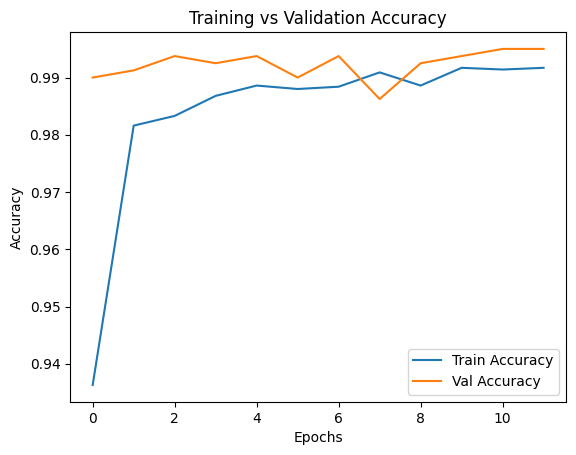

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

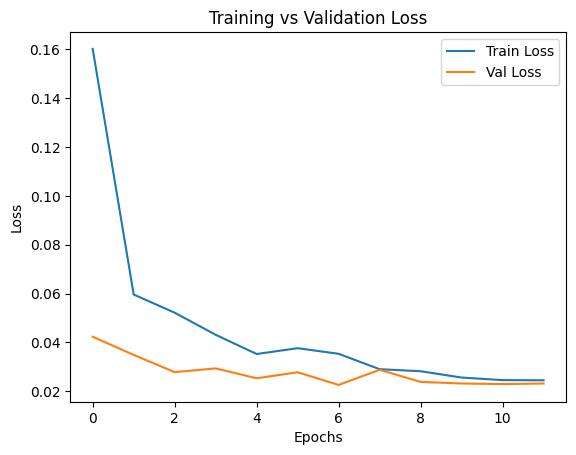

In [12]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 12. Evaluate on Test Set

In [13]:
loss, accuracy = model.evaluate(test_gen)
print(f"\n[INFO] Test Accuracy: {accuracy:.4f}")

C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9911 - loss: 0.0264

[INFO] Test Accuracy: 0.9890


## 13. Classification Report
1. Predict class probabilities for each image in the test set.
2. Apply a threshold (0.5) to convert probability into class label (0 or 1).
    Example: [0.92, 0.34, 0.67] → [1, 0, 1
3. Get the actual ground-truth labels for each test image.
4. Extract class names from the generator (e.g., `['WithMask', 'WithoutMask']`)
5. Display a classification report comparing true and predicted labels.

In [14]:
# Classification report
import numpy as np 
pred_probs = model.predict(test_gen)
pred_labels = (pred_probs > 0.5).astype("int32").reshape(-1)
true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step

Classification Report:
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       487
 WithoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       996
   macro avg       0.99      0.99      0.99       996
weighted avg       0.99      0.99      0.99       996



## 14. Load Saved Model

In [15]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("mask_detector_sigmoid_best.h5")

## 15. Predict on New Images
We now define a function that allows us to make predictions on any new image using our trained MobileNetV2-based model.

This function:
- Loads and resizes the input image to 224×224 (required by MobileNetV2)
- Converts it to a NumPy array and expands its shape to match model input
- Applies MobileNetV2-specific preprocessing (`preprocess_input`)
- Uses the trained model to predict the class
- Converts the output into a human-readable label
- Displays the image with the predicted label

In [16]:
from tensorflow.keras.preprocessing import image

def predict_mask(img_path,model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)   # Convert to NumPy array
    img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension: (1, 256, 256, 3)
    img_array = preprocess_input(img_array)   # Normalize pixel values to expected format
    
    # Predict
    pred = model.predict(img_array)
    class_index = 1 if pred[0][0] > 0.5 else 0
    class_label = list(test_gen.class_indices.keys())[class_index]
    
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


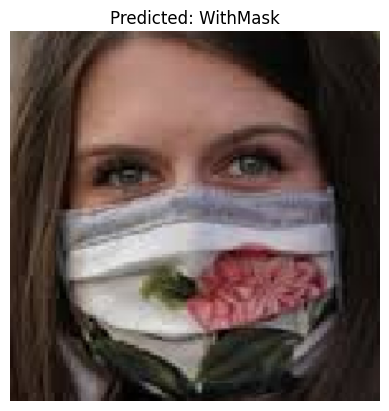

In [17]:
img_path = 'face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/187.png'
predict_mask(img_path,model)

## 16. Real-Time Face Mask Detection via Webcam

Summary:
1. Webcam captures one frame at a time
2. Frame is resized, preprocessed, and passed to model
3. Model predicts class
4. Label is drawn on the frame using cv2.putText
5. Frame is displayed in a window that updates in real time

In [18]:
import cv2

def predict_mask_from_frame(frame, model):
    # Resize frame to match model input
    img = cv2.resize(frame, (224, 224))
    img_array = np.expand_dims(img, axis=0)
    img_array = preprocess_input(img_array)
    
    # Predict
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)  # 0 or 1
    class_label = "Without Mask" if prediction[0][0] > 0.5 else "With Mask"
    color = (0, 255, 0) if class_label == "With Mask" else (0, 0, 255)

    # Draw label on the original frame (not resized)
    cv2.putText(frame, f"Prediction: {class_label}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    return frame

In [20]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = predict_mask_from_frame(frame, model)
    cv2.imshow('Webcam', frame)

    if cv2.waitKey(1) & 0xFF == ord('x'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━

#  17. Project Summary

In this project, we successfully built a deep learning-based face mask detection system using transfer learning with MobileNetV2.

## 🔧 What We Did:
- Used a labeled dataset of over 12,000 images, categorized into "With Mask" and "Without Mask".
- Applied image preprocessing and powerful data augmentation techniques (rotation, zoom, shift, flip) to improve model generalization.
- Utilized MobileNetV2 pre-trained on ImageNet and added custom classification layers for binary output.
- Replaced the final dense layer with a sigmoid-activated neuron for binary classification.
- Trained the model using:
  - Early stopping to prevent overfitting
  - ModelCheckpoint to save the best-performing model
- Evaluated model performance on the test set using:
  - Accuracy metric
  - A detailed classification report including precision, recall, and F1-score
- Visualized training and validation accuracy and loss curves.
- Built real-world prediction capabilities by:
  - Predicting on new uploaded images
  - Running real-time webcam detection using OpenCV and live video feed

## ✅ Final Performance
- 📈 Test Accuracy: 98.9%
- 📊 F1-Score: 0.99 (both classes: With Mask, Without Mask)

##  Applications
This model is ready for deployment in real-world scenarios such as:
- Public surveillance systems
- Mask compliance monitoring in hospitals, airports, schools